In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from subprocess import check_output
print(check_output(["ls","../data/titanic"]).decode("utf8"))

train_data = pd.read_csv('../data/titanic/train.csv', dtype={'Age': np.float16})

train_data.head()

gender_submission.csv
test.csv
train.csv



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.687500,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.523438,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.419922,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float16
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float16(1), float64(1), int64(5), object(5)
memory usage: 78.4+ KB


In [4]:
null_columns=train_data.columns[train_data.isnull().any()]
print('Train columns with null values:\n', train_data.isnull().sum())
print("-" * 10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------


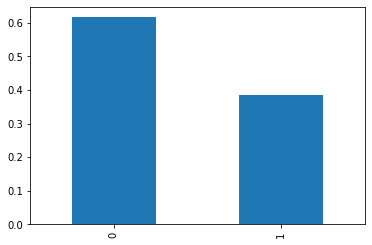

In [5]:
train_data.Survived.value_counts(normalize=True).plot(kind="bar")

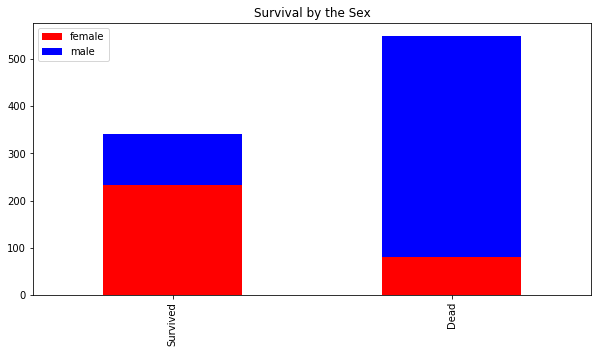

In [6]:
survived_sex = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead_sex = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(10,5), color=['red','blue'], title='Survival by the Sex')

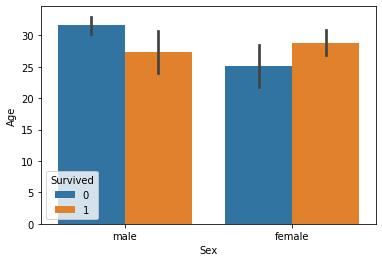

In [7]:
sns.barplot(x='Sex',y='Age',hue='Survived',data=train_data)

Text(0.5, 1.0, 'Age Survived')

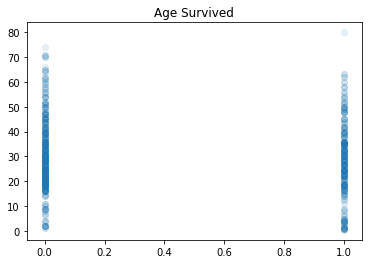

In [8]:
plt.scatter(train_data.Survived, train_data.Age, alpha=0.1)   ## here the plot has to be transparent so we need to pic low alpha value
plt.title("Age Survived")

In [9]:
Male_titanic = train_data.loc[train_data.Sex== 'male',:]
Female_titanic = train_data.loc[train_data.Sex== 'female',:]

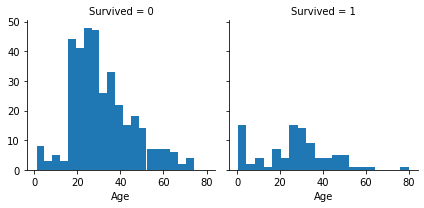

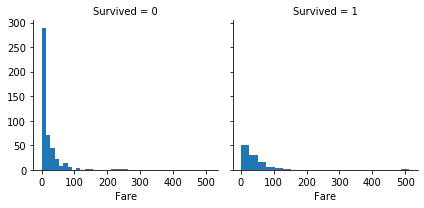

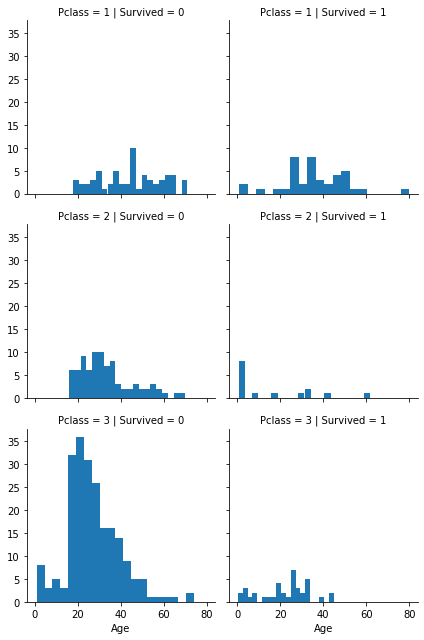

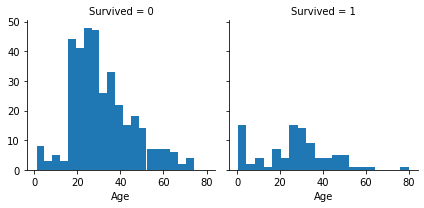

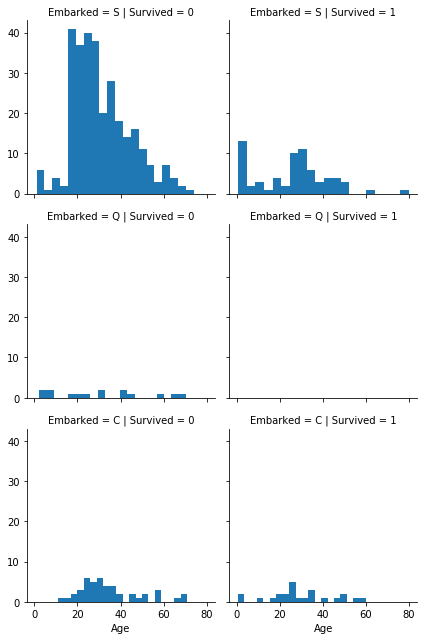

In [10]:
g0=sns.FacetGrid(Male_titanic, col='Survived')
g0.map(plt.hist, 'Age', bins=20)
g1=sns.FacetGrid(Male_titanic, col='Survived')
g1.map(plt.hist, 'Fare', bins=20)
g2=sns.FacetGrid(Male_titanic, col='Survived', row='Pclass')
g2.map(plt.hist, 'Age', bins=20)
g3=sns.FacetGrid(Male_titanic, col='Survived')
g3.map(plt.hist, 'Age', bins=20)
g4=sns.FacetGrid(Male_titanic, col='Survived', row='Embarked')
g4.map(plt.hist, 'Age', bins=20)

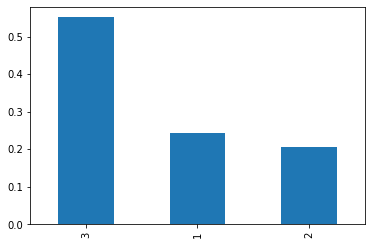

In [11]:
train_data.Pclass.value_counts(normalize=True).plot(kind="bar")

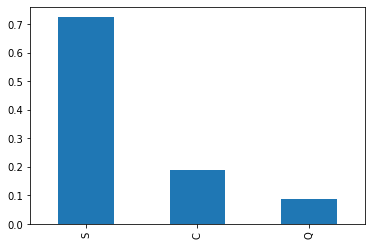

In [12]:
train_data.Embarked.value_counts(normalize=True).plot(kind="bar")

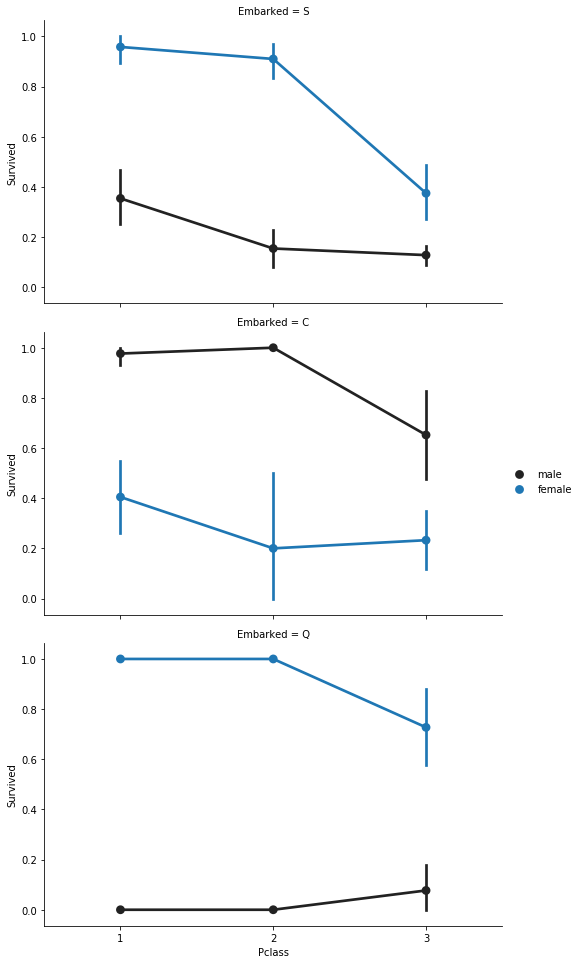

In [13]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

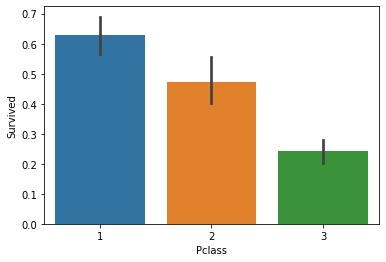

In [14]:
sns.barplot(x='Pclass', y='Survived', data=train_data)

In [15]:
data = [train_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

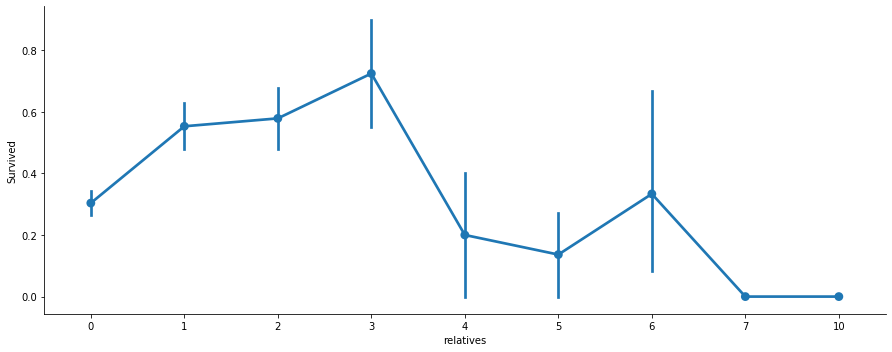

In [16]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_data, aspect = 2.5, )

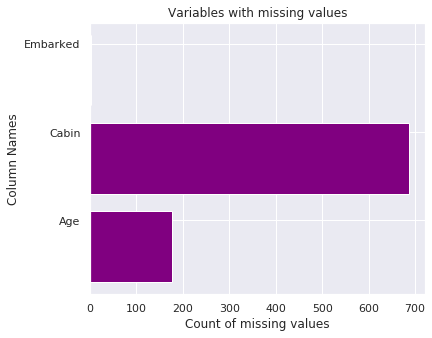

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

# pd.options.display.mpl_style = 'default'
labels = []
values = []
for col in null_columns:
    labels.append(col)
    values.append(train_data[col].isnull().sum())
ind = np.arange(len(labels))
ind
width=0.6
fig, ax = plt.subplots(figsize=(6,5))
rects = ax.barh(ind, np.array(values), color='purple')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_ylabel("Column Names")
ax.set_title("Variables with missing values");

In [18]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [19]:
train_data=train_data.drop(['Cabin','PassengerId',"Ticket","Fare"], axis=1)

In [20]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S,0,1


In [21]:
data = [train_data]
for dataset in data:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)
    Embarked = np.zeros(len(dataset))
    Embarked[dataset['Embarked']== 'C'] = 1
    Embarked[dataset['Embarked']== 'Q'] = 2
    Embarked[dataset['Embarked']== 'S'] = 3
    dataset['Embarked'] = Embarked

In [22]:
train_data['Age'].fillna(train_data['Age'].median(), inplace = True)

In [23]:
print('Train columns with null values:\n', train_data.isnull().sum())
print("-" * 10)

Train columns with null values:
 Survived     0
Pclass       0
Name         0
Sex          0
Age          0
SibSp        0
Parch        0
Embarked     0
relatives    0
not_alone    0
dtype: int64
----------


In [24]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,3.0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,1.0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,3.0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,3.0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,3.0,0,1


In [25]:
data = [train_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_data = train_data.drop(['Name'], axis=1)

In [26]:
data = [train_data]
for dataset in data:
    sex = np.zeros(len(dataset))
    sex[dataset['Sex']== 'male'] = 1
    sex[dataset['Sex']== 'female'] = 0
    dataset['Sex'] = sex

In [27]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,relatives,not_alone,Title
0,0,3,1.0,22.0,1,0,3.0,1,0,1
1,1,1,0.0,38.0,1,0,1.0,1,0,3
2,1,3,0.0,26.0,0,0,3.0,0,1,2
3,1,1,0.0,35.0,1,0,3.0,1,0,3
4,0,3,1.0,35.0,0,0,3.0,0,1,1


In [28]:
X = train_data.drop("Survived", axis=1)
y= train_data["Survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size = 0.20)

In [29]:
logreg = LogisticRegression(C=1e3, solver='liblinear', multi_class='auto')
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
logreg_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
acc_log_test = round(logreg.score(X_test, Y_test) * 100, 2)

print("LOGREG score =" ,acc_log)
print("AUC SCORE = " ,logreg_auc_score)
print("LOGREG score test =" ,acc_log_test)

LOGREG score = 81.74
AUC SCORE =  75.95
LOGREG score test = 78.21


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[98 20]
 [19 42]]


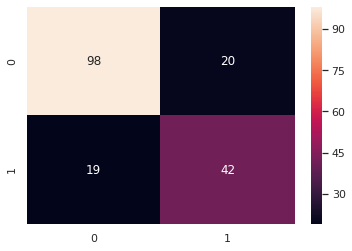

In [31]:
sns.heatmap(confusion_matrix, annot=True)

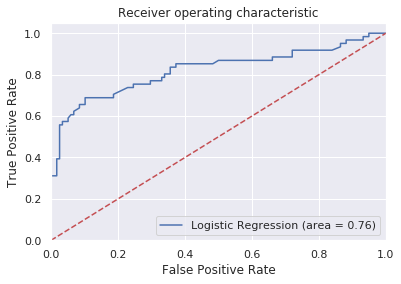

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [33]:
knn = KNeighborsClassifier(n_neighbors = 3)  #Default is Minkowski with p=2 which means Euclidean
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 3)
print("KNN SCORE =" ,acc_knn)
knn_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 3)
print("AUC SCORE = " ,knn_auc_score)
acc_knn_test = round(knn.score(X_test, Y_test) * 100, 3)
print("KNN SCORE TEST =" ,acc_knn_test)

KNN SCORE = 87.64
AUC SCORE =  73.548
KNN SCORE TEST = 77.654


In [60]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 3)
print("NAIVE BAYES SCORE =" , acc_gaussian)
gauss_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 3)
print("AUC SCORE = " ,gauss_auc_score)
acc_gaussian_test=round(gaussian.score(X_test, Y_test) * 100, 3)
print("NAIVE BAYES SCORE TEST =" , acc_gaussian_test)

NAIVE BAYES SCORE = 80.478
AUC SCORE =  75.472
NAIVE BAYES SCORE TEST = 76.536


In [61]:
linear_svc = SVC(C=100, kernel="linear", random_state=1)
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 3)
print("SVM score =" ,acc_linear_svc)
linear_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 3)
print("AUC SCORE = " ,linear_auc_score)
acc_linear_svc_test = round(linear_svc.score(X_test, Y_test) * 100, 3)
print("SVM score test =" ,acc_linear_svc_test)

SVM score = 82.163
AUC SCORE =  77.195
SVM score test = 79.33


In [36]:
"""TEK BİR KARAR AĞACI İLE ÇÖZÜM"""

dtc_scores = []
dtc_scores_test = []
dtc_auc_scores = []

for x in range(1,10):   
    decision_tree = tree.DecisionTreeClassifier(criterion="gini",max_depth=x)
    decision_tree.fit(X_train, Y_train)
    Y_pred=decision_tree.predict(X_test)
    
    acc_dtc = round(decision_tree.score(X_train, Y_train) * 100, 2)
    dtc_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_dtctest = round(decision_tree.score(X_test, Y_test) * 100, 2)
    
    print("Decision Tree Train score for {} depth =".format(x) ,acc_dtc)
    print("Decision Tree Test score for {} depth = ".format(x) ,acc_dtctest)
    print("AUC SCORE for {} depth =".format(x)  ,dtc_auc_score , "\n")
    
    dtc_scores.append(acc_dtc)
    dtc_auc_scores.append(dtc_auc_score)
    dtc_scores_test.append(acc_dtctest)
    

print("Train Scores list:", dtc_scores)
print("Test Scores list:",dtc_scores_test)
print("AUC list:",dtc_auc_scores)

Decision Tree Train score for 1 depth = 78.65
Decision Tree Test score for 1 depth =  76.54
AUC SCORE for 1 depth = 75.47 

Decision Tree Train score for 2 depth = 82.16
Decision Tree Test score for 2 depth =  79.89
AUC SCORE for 2 depth = 77.62 

Decision Tree Train score for 3 depth = 83.85
Decision Tree Test score for 3 depth =  80.45
AUC SCORE for 3 depth = 78.04 

Decision Tree Train score for 4 depth = 85.25
Decision Tree Test score for 4 depth =  78.77
AUC SCORE for 4 depth = 77.17 

Decision Tree Train score for 5 depth = 86.1
Decision Tree Test score for 5 depth =  79.33
AUC SCORE for 5 depth = 76.8 

Decision Tree Train score for 6 depth = 87.92
Decision Tree Test score for 6 depth =  75.98
AUC SCORE for 6 depth = 75.05 

Decision Tree Train score for 7 depth = 89.19
Decision Tree Test score for 7 depth =  77.65
AUC SCORE for 7 depth = 75.92 

Decision Tree Train score for 8 depth = 90.45
Decision Tree Test score for 8 depth =  74.86
AUC SCORE for 8 depth = 72.22 

Decision T

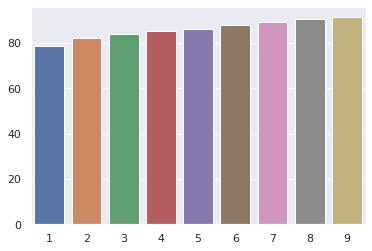

In [37]:
ax = sns.barplot(x= list(range(1,10)) , y= dtc_scores)

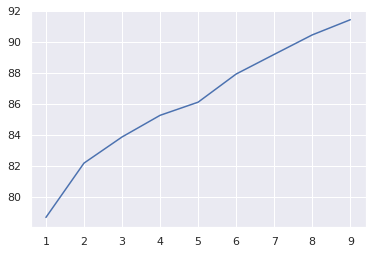

In [38]:
sns.set(style="darkgrid")
sns.lineplot(x= list(range(1,10)) , y= dtc_scores)

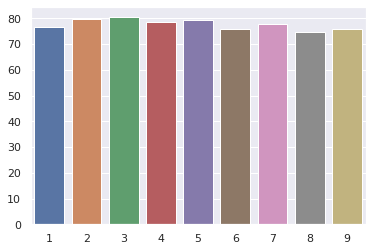

In [39]:
ax = sns.barplot(x= list(range(1,10)) , y= dtc_scores_test)

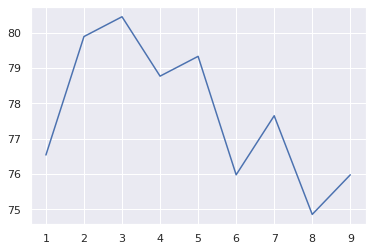

In [40]:
sns.set(style="darkgrid")
sns.lineplot(x= list(range(1,10)) , y= dtc_scores_test)

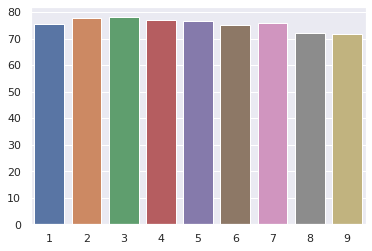

In [41]:
ax = sns.barplot(x= list(range(1,10)) , y= dtc_auc_scores)

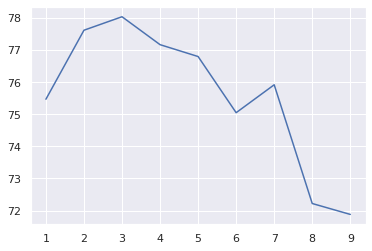

In [42]:
sns.set(style="darkgrid")
sns.lineplot(x= list(range(1,10)) , y= dtc_auc_scores)

In [43]:
"""BAGGING KULLANARAK YAPILAN KARAR AĞACI ÇÖZÜMÜ"""

samples = [5,10,25,50,100,250,500]
scores = []
scores_test = []
auc_scores = []

for x in samples:   
    bg = BaggingClassifier(DecisionTreeClassifier(),max_samples=x, 
                       max_features=1.0, n_estimators=25, 
                       bootstrap = True)
    bg.fit(X_train,Y_train)
    Y_pred = bg.predict(X_test)

    acc_bgdtc = round(bg.score(X_train, Y_train) * 100, 2)
    bg_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_bgdtctest = round(bg.score(X_test, Y_test) * 100, 2)

    print("Bagging Decision Tree Train score for {} samples =".format(x) ,acc_bgdtc)
    print("Bagging Decision Tree Test score for {} samples = ".format(x) ,acc_bgdtctest)
    print("AUC SCORE for {} samples =".format(x)  ,bg_auc_score , "\n")
    scores.append(acc_bgdtc)
    auc_scores.append(bg_auc_score)
    scores_test.append(acc_bgdtctest)
    

print("Train Scores list:", scores)
print("Test Scores list:",scores_test)
print("AUC list:",auc_scores)

Bagging Decision Tree Train score for 5 samples = 75.56
Bagging Decision Tree Test score for 5 samples =  81.01
AUC SCORE for 5 samples = 73.71 

Bagging Decision Tree Train score for 10 samples = 78.51
Bagging Decision Tree Test score for 10 samples =  77.09
AUC SCORE for 10 samples = 74.71 

Bagging Decision Tree Train score for 25 samples = 81.6
Bagging Decision Tree Test score for 25 samples =  78.77
AUC SCORE for 25 samples = 76.77 

Bagging Decision Tree Train score for 50 samples = 83.01
Bagging Decision Tree Test score for 50 samples =  78.77
AUC SCORE for 50 samples = 76.38 

Bagging Decision Tree Train score for 100 samples = 87.08
Bagging Decision Tree Test score for 100 samples =  78.21
AUC SCORE for 100 samples = 75.95 

Bagging Decision Tree Train score for 250 samples = 89.75
Bagging Decision Tree Test score for 250 samples =  79.89
AUC SCORE for 250 samples = 76.83 

Bagging Decision Tree Train score for 500 samples = 93.26
Bagging Decision Tree Test score for 500 sampl

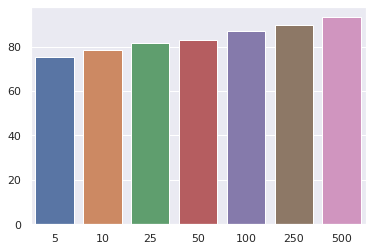

In [44]:
ax = sns.barplot(x= samples , y= scores)

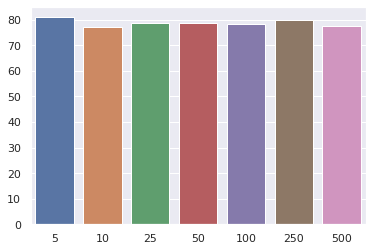

In [45]:
ax = sns.barplot(x= samples , y= scores_test)

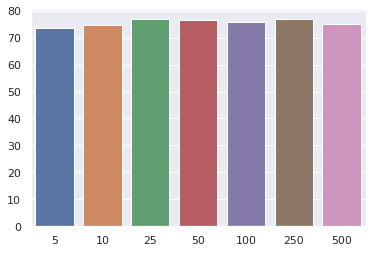

In [46]:
ax = sns.barplot(x= samples , y= auc_scores)

In [47]:
"""RANDOM FOREST ÇÖZÜMÜ"""
estimators = [5,10,25,30,40,50]
rfc_scores = []
rfc_scores_test = []
rfc_auc_scores = []

for x in estimators:   
    rf = RandomForestClassifier(criterion='gini',n_estimators=x,bootstrap= False,
                                max_depth=3,max_features='auto')
    rf.fit(X_train,Y_train)
    
    Y_pred = rf.predict(X_test)

    acc_rf = round(rf.score(X_train, Y_train) * 100, 2)
    rf_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_rftest = round(rf.score(X_test, Y_test) * 100, 2)

    print("Random Forest Train score for {} estimators =".format(x) ,acc_rf)
    print("Random Forest Test score for {} estimators = ".format(x) ,acc_rftest)
    print("AUC SCORE for {} estimators =".format(x)  ,rf_auc_score , "\n")
    rfc_scores.append(acc_rf)
    rfc_auc_scores.append(rf_auc_score)
    rfc_scores_test.append(acc_rftest)
    
print("Train Scores list:", rfc_scores)
print("Test Scores list:",rfc_scores_test)
print("AUC list:",rfc_auc_scores)

Random Forest Train score for 5 estimators = 83.85
Random Forest Test score for 5 estimators =  80.45
AUC SCORE for 5 estimators = 78.04 

Random Forest Train score for 10 estimators = 83.57
Random Forest Test score for 10 estimators =  80.45
AUC SCORE for 10 estimators = 78.04 

Random Forest Train score for 25 estimators = 83.85
Random Forest Test score for 25 estimators =  81.01
AUC SCORE for 25 estimators = 78.86 

Random Forest Train score for 30 estimators = 84.13
Random Forest Test score for 30 estimators =  80.45
AUC SCORE for 30 estimators = 78.04 

Random Forest Train score for 40 estimators = 84.13
Random Forest Test score for 40 estimators =  80.45
AUC SCORE for 40 estimators = 78.04 

Random Forest Train score for 50 estimators = 84.41
Random Forest Test score for 50 estimators =  80.45
AUC SCORE for 50 estimators = 78.04 

Train Scores list: [83.85, 83.57, 83.85, 84.13, 84.13, 84.41]
Test Scores list: [80.45, 80.45, 81.01, 80.45, 80.45, 80.45]
AUC list: [78.04, 78.04, 78.

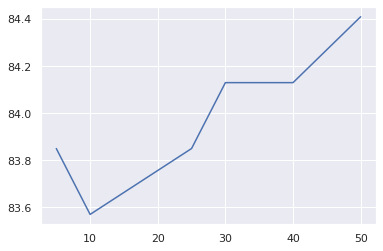

In [48]:
sns.set(style="darkgrid")
sns.lineplot(x= estimators , y= rfc_scores)

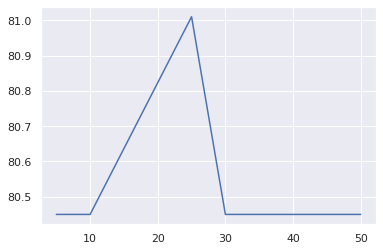

In [49]:
ax = sns.lineplot(x= estimators , y= rfc_scores_test)

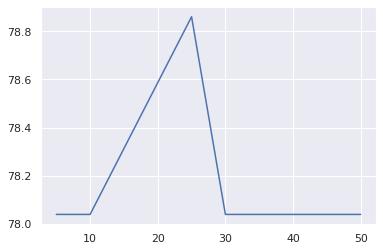

In [50]:
ax = sns.lineplot(x= estimators , y= rfc_auc_scores)

In [51]:
"""ADABOOST"""
estimators = [5,10,25,30,40,50,100,250,500,1000]
adb_rfc_scores = []
adb_rfc_scores_test = []
adb_rfc_auc_scores = []
for x in estimators:
    ad=AdaBoostClassifier(RandomForestClassifier(), n_estimators=x)
    ad.fit(X_train,Y_train)
    Y_pred = ad.predict(X_test)

    acc_adb_rfc = round(ad.score(X_train, Y_train) * 100, 2)
    adb_rfc_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)
    acc_adb_rfctest = round(ad.score(X_test, Y_test) * 100, 2)

    print("ADABOOST Random Forest Train score for {} estimators =".format(x) ,acc_adb_rfc)
    print("ADABOOST Random Forest Test score for {} estimators = ".format(x) ,acc_adb_rfctest)
    print("AUC SCORE for {} estimators =".format(x)  ,adb_rfc_auc_score , "\n")
    adb_rfc_scores.append(acc_adb_rfc)
    adb_rfc_auc_scores.append(adb_rfc_auc_score)
    adb_rfc_scores_test.append(acc_adb_rfctest)
    
print("Train Scores list:", adb_rfc_scores)
print("Test Scores list:",adb_rfc_scores_test)
print("AUC list:",adb_rfc_auc_scores)


ADABOOST Random Forest Train score for 5 estimators = 94.66
ADABOOST Random Forest Test score for 5 estimators =  77.09
AUC SCORE for 5 estimators = 74.71 

ADABOOST Random Forest Train score for 10 estimators = 94.66
ADABOOST Random Forest Test score for 10 estimators =  78.21
AUC SCORE for 10 estimators = 75.16 

ADABOOST Random Forest Train score for 25 estimators = 94.66
ADABOOST Random Forest Test score for 25 estimators =  78.21
AUC SCORE for 25 estimators = 76.35 

ADABOOST Random Forest Train score for 30 estimators = 94.66
ADABOOST Random Forest Test score for 30 estimators =  77.09
AUC SCORE for 30 estimators = 74.71 

ADABOOST Random Forest Train score for 40 estimators = 94.66
ADABOOST Random Forest Test score for 40 estimators =  77.65
AUC SCORE for 40 estimators = 75.53 

ADABOOST Random Forest Train score for 50 estimators = 94.66
ADABOOST Random Forest Test score for 50 estimators =  78.21
AUC SCORE for 50 estimators = 75.56 

ADABOOST Random Forest Train score for 100 

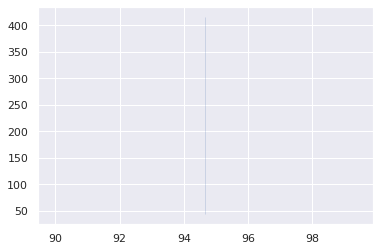

In [52]:
sns.lineplot(x= adb_rfc_scores , y= estimators)

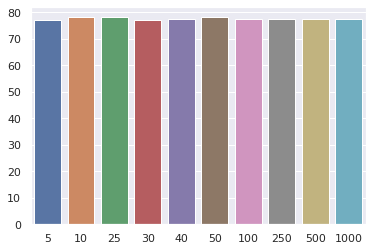

In [53]:
sns.barplot(x= estimators , y= adb_rfc_scores_test)

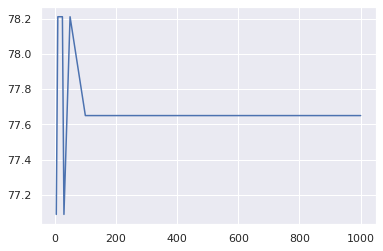

In [54]:
sns.lineplot(x= estimators , y= adb_rfc_scores_test)

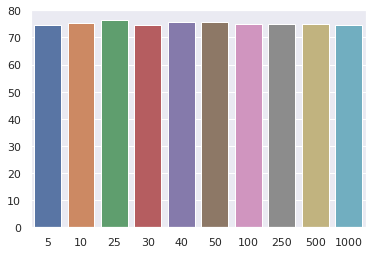

In [55]:
sns.barplot(x= estimators , y= adb_rfc_auc_scores)

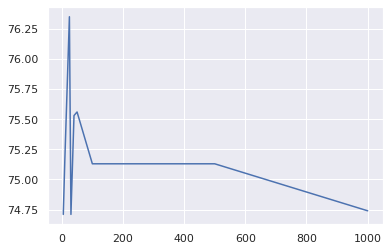

In [56]:
sns.lineplot(x= estimators , y= adb_rfc_auc_scores)

In [57]:
"""GENEL KARŞILAŞTIRMALAR"""

classifiers=["Log Reg","KNN","NB","SVM","DTree","RForest","BGDT","ADBRF"]
results=[79.866,79.357,81.917,80.447,83.39,82.56,82.52,83.8]

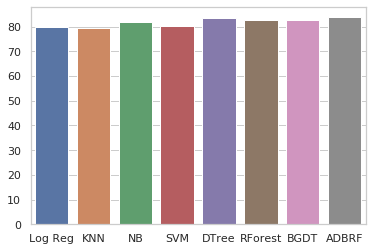

In [58]:
sns.set(style="whitegrid")
ax=sns.barplot(x= classifiers , y= results)

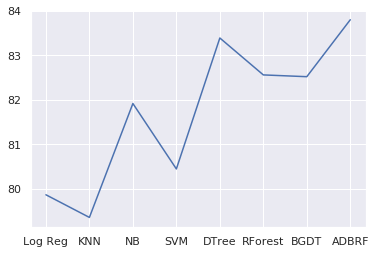

In [59]:
sns.set(style="darkgrid")
ax= sns.lineplot(x= classifiers , y= results,sort=False)